# Detecting statistical boundaries.
    
In statistical learning (SL) paradigms participants are continuously and repeatedly shown items (e.g., novel objects) with little to no semantic or perceptual differences from one another. During passive viewing, participants are able to form these items into groups i.e., events, based purely on shared co-occurrences between items across repeated exposures. Knowledge of these events is measured with a surprise recognition test after passive exposure. While this test has proven to reflect participants' familiarity with events it has 2 important limitations. 
    
1) Because participants can solve the recognition test with multiple strategies it doesn’t probe the specificity of participants' event knowledge

2) Because there is no behavioral index of event knowledge during learning it can’t provide insight into how participants are actually forming event knowledge across repetitions. 

These paradigms are powerful because they allow the researcher to probe the capacity to take continuous experience and form discrete events by detecting patterns across repeated experiences. We are proposing a new measure that will allow us to probe the specificity of event knowledge after learning and detect the formation of event knowledge during learning.

## data import and cleaning

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pat = pd.read_csv('data/temple_pattern_all_participants_2021-05-24_cleaned.csv')
rem = pd.read_csv('data/temple_remember_all_participants_2021-05-24_cleaned.csv')
pat.drop(['date'], axis=1, inplace=True)
rem.drop(['date'], axis=1, inplace=True)
pat = pat[pat.participant!=1]
rem = rem[rem.participant!=1]
pat['image1_key_resp.keys'].replace(to_replace={'f':'begin', 'j':'end'}, inplace = True)
pat['image2_key_resp.keys'].replace(to_replace={'f':'begin', 'j':'end'}, inplace = True)
pat['image3_key_resp.keys'].replace(to_replace={'f':'begin', 'j':'end'}, inplace = True)
pat['image1_key_resp.keys'].replace(to_replace={'f,j':'begin', 'j,f':'end'}, inplace = True)
pat['image2_key_resp.keys'].replace(to_replace={'f,j':'begin', 'j,f':'end'}, inplace = True)
pat['image3_key_resp.keys'].replace(to_replace={'f,j':'begin', 'j,f':'end'}, inplace = True)

def correct_resp(r):
    i1_correct = r['i1_corr'] # 1 or 0 - is the image 1 part of correct sequence?
    i1_side = r['l_or_r'] # 1 left, 2 right - which side of screen is image 1 presented?
    if (i1_correct == 1 and i1_side == 1):
        correct = 1
    elif (i1_correct == 1 and i1_side == 2):
        correct = 2
    elif (i1_correct == 0 and i1_side == 1):
        correct = 2
    elif (i1_correct == 0 and i1_side == 2):
        correct = 1
    return correct

In [4]:
# transitioning data from wide format to long format.
id_vars = ['trial', 'participant','OS']
un_pivot_vars1 = ['image1_key_resp.keys', 'image2_key_resp.keys','image3_key_resp.keys']
un_pivot_vars2 = ['image1_key_resp.rt', 'image2_key_resp.rt','image3_key_resp.rt']
un_pivot_vars3 = ['image1', 'image2', 'image3']
pat
up1 = pat[ id_vars + un_pivot_vars1 ].melt(id_vars = id_vars, value_vars = un_pivot_vars1, 
                                           var_name = 'old_var1', value_name = 'indication').sort_values(['participant','trial']).drop('old_var1', axis=1)
up2 = pat[ id_vars + un_pivot_vars2 ].melt(id_vars = id_vars, value_vars = un_pivot_vars2,
                                           var_name = 'old_var2', value_name = 'rt').sort_values(['participant','trial']).drop('old_var2', axis=1)
up3 = pat[ id_vars + un_pivot_vars3 ].melt(id_vars = id_vars, value_vars = un_pivot_vars3,
                                           var_name = 'old_var3', value_name = 'image id').sort_values(['participant','trial']).drop('old_var3', axis=1)

up1['position'] = np.tile(['1', '2', '3'], int(len(up1)/3))
up2['position'] = np.tile(['1', '2', '3'], int(len(up2)/3))
up3['position'] = np.tile(['1', '2', '3'], int(len(up3)/3))

t1 = pd.merge(up1, up2, how="inner", on=['trial', 'participant', 'OS', 'position'])
pdf = pd.merge(t1, up3, how="inner", on=['trial', 'participant', 'OS', 'position'])
pdf['key press'] = (~pdf[['indication']].isnull()) * 1

# this gets actual trials since in long format there were 3 parses per trial
total_keys = ((pdf[['participant', 'trial']].groupby(['participant']).max()+1)*3).to_dict()['trial']
x = []
for key, val in total_keys.items():
    y = pd.DataFrame(np.vstack([np.repeat(key, val), np.arange(val)])).T
    y.columns = ['participant','i trial']
    x.append(y)
z = pd.concat(x)
pdf['i trial'] = z['i trial'].values + 1
pdf.to_csv('data/temple_bound_long_format.csv')
df = pdf.copy()

# Can participants detect event boundaries in a continuous stream?

After viewing a stream of objects for ~5 minutes (with triplet structure), we presented the same structure again and asked participants to indicate the beginning and end of triplet events.

Specfically, we told participants that they will view a stream of objects and that a pattern exists in the stream of objects and that we want them to pick out these patterns. We walked participants through a few examples of streams with pairs (X1 → X2) and quadruplets (X1 → X2 → X3 → X4). We instructed them to press a button when they think a pattern is beginning and a different button when they think a pattern is ending. 

If participants can detect events we would expect participants to indicate a 'begin' press at the start of a triplet and an 'end' press at the end of a triplet.



Integrated objects will be operationalized as all the objects from the ‘1’ button press up to the ‘2’ button press. An event boundary will be operationalized as a ‘2’ button press followed by a ‘1’ button press. We expect participants to successfully integrate object pairs and triplets before detecting event boundaries.

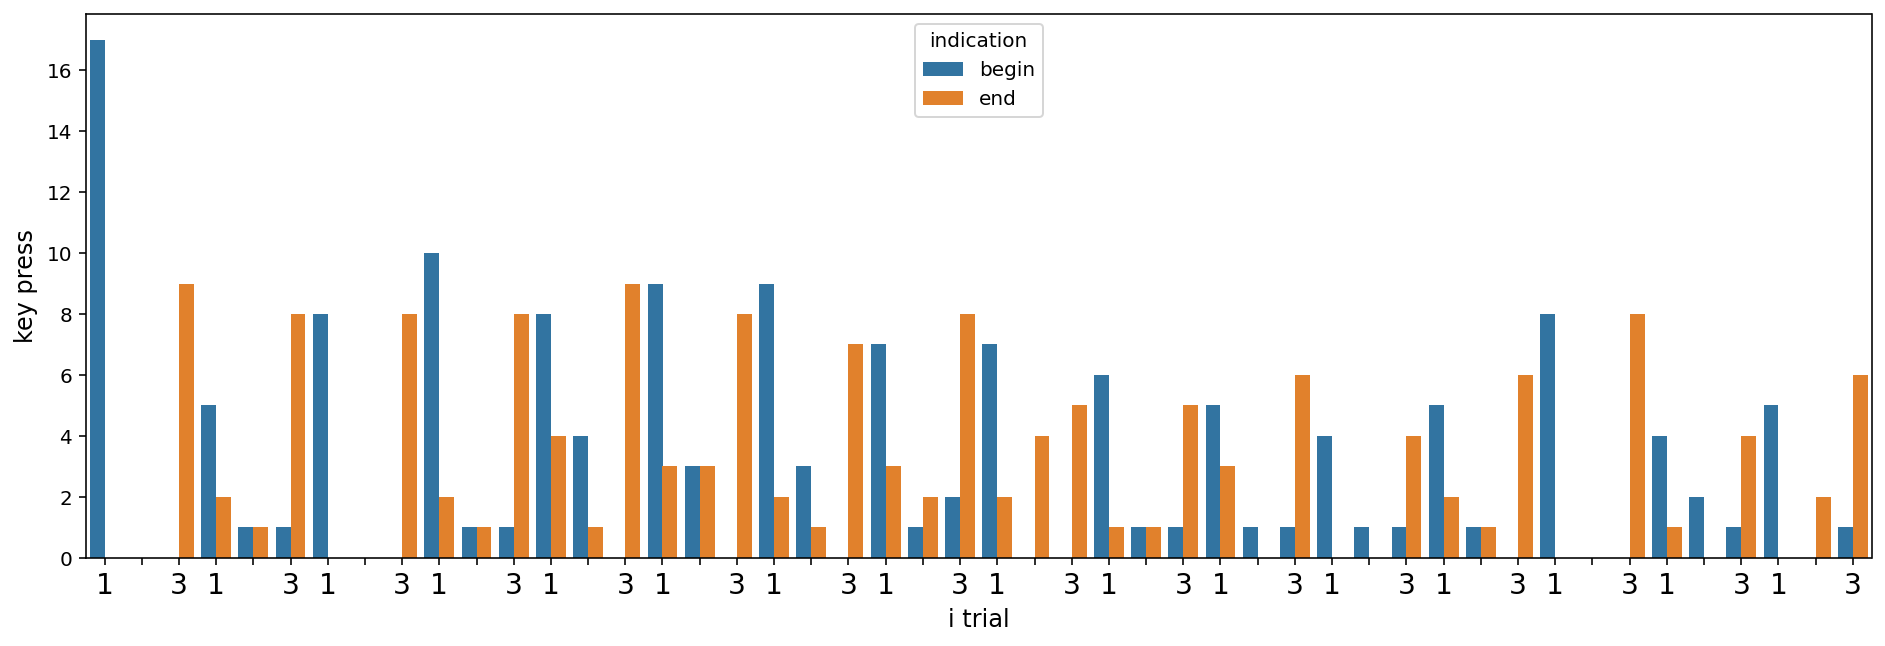

In [24]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['figure.figsize'] = (16,5)
totals = df[['participant', 'i trial', 'indication', 'key press']].groupby(['indication', 'i trial']).sum().reset_index()
g = sns.barplot(x="i trial", y="key press", hue='indication', order=np.arange(1,df.loc[:,'i trial'].max()+1), data=totals)
g.set_xticklabels(np.tile(['1', '', '3'], int(48/3)), size=14)
None

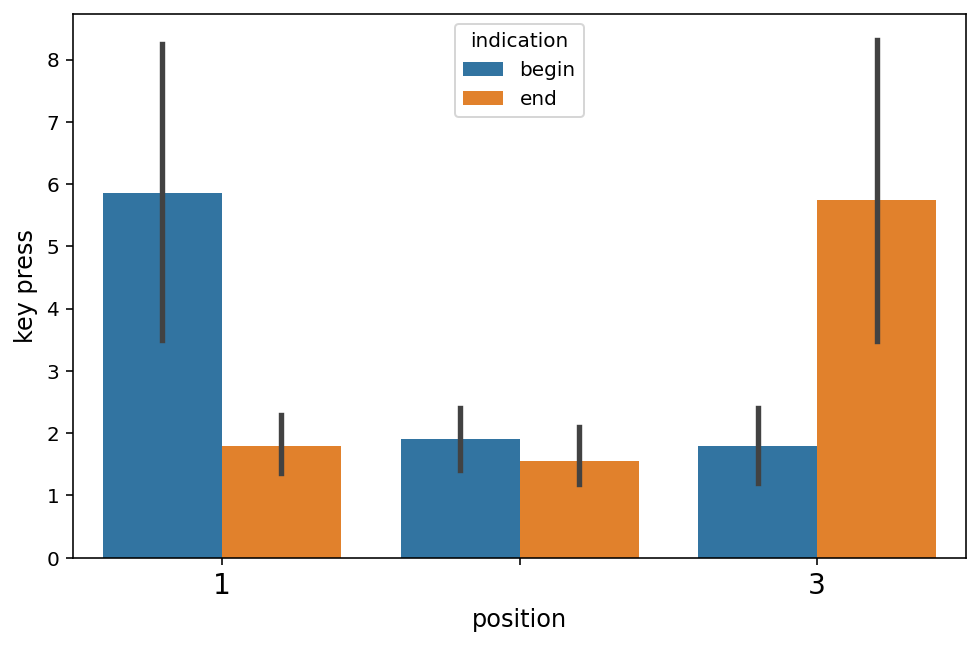

In [31]:
plt.rcParams['figure.figsize'] = (8,5)
totals = df[['participant', 'position', 'indication', 'key press']].groupby(['participant', 'indication', 'position']).count().reset_index()
g = sns.barplot(x="position", y="key press", hue='indication', order=['1', '2', '3'], data=totals)
g.set_xticklabels(['1', '', '3'], size=14)
None

- It's clear that participants generally are able to detect event boundaries, this is clearly driven by a subset of participants (seen in the 'by participant' plot below).

### by participant

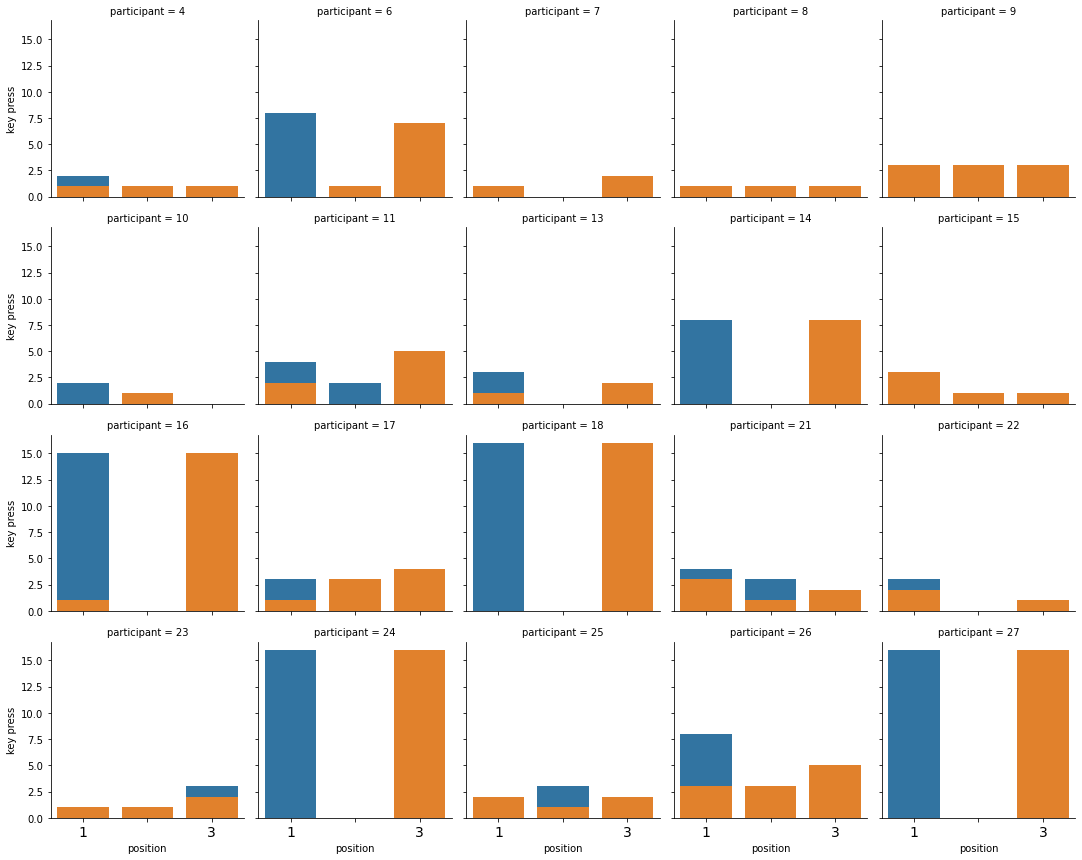

In [22]:
totals = df[['participant', 'position', 'indication', 'key press']].groupby(['participant', 'indication', 'position']).count().reset_index()
g = sns.FacetGrid(totals, col='participant', col_wrap=5, hue='indication')
g.map(sns.barplot, "position", "key press", order=['1', '2', '3'])
g.set_xticklabels(['1', '', '3'], size=14)
None

## what is the probability a participant will indicate the beginning and end of an event?

In [15]:
totals = pdf[['participant', 'position', 'indication', 'key press']].groupby(['participant', 'indication', 'position']).count().reset_index()

## what are the complete events that participants are detecting?

# The relationship between parsing and memory.

This idea here is that people can perform well on the task without explicit knowledge about the event boundaries. This suggests the event representations don't need to be well formed (at all) to perform well on the remembeer task.

In [6]:
# these responses from the remember game don't have the correct response coded
# - here we will use the pattern game to code the correct responses to the remember game

# get the true pattern (from pattern game) and set to correct
true = pat[['participant','image1','image2','image3']].drop_duplicates()
true['i1_corr'] = 1
rem_clean = rem.merge(true, how='outer', on=['participant','image1','image2','image3']).sort_values(['participant','trial'])
rem_clean.loc[rem_clean['i1_corr'].isnull(), 'i1_corr'] = 0
rem_clean['correct_resp'] = rem_clean.apply(correct_resp, axis=1)
rem_clean['accuracy'] = (rem_clean.correct_resp.to_numpy() == rem_clean[['key_resp_2.keys']].to_numpy().squeeze()) * 1
rdf = rem_clean.copy()

<AxesSubplot:xlabel='participant', ylabel='accuracy'>

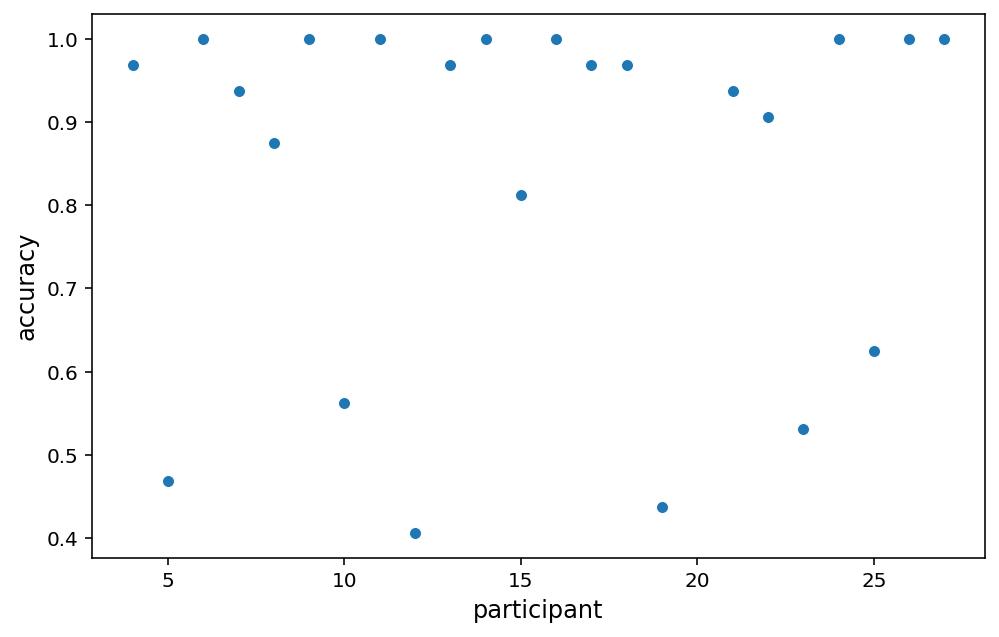

In [12]:
rdf.columns
totals = rdf[['participant', 'trial', 'accuracy']].groupby(['participant']).mean().reset_index()
sns.scatterplot(x='participant', y='accuracy', data=totals)